# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.1
sys_mnoise_sd = 1e-2

0.01

In [3]:
N = 300
Δt = 0.05
tsteps = range(0.0, step=Δt, length=N)

0.0:0.05:14.95

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
init_state = [π/2, 0.0]
pendulum = SPendulum(init_state, sys_mass, sys_length, sys_damping, sys_mnoise_sd, Δt=Δt)

states = zeros(2,N)
observations = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
end

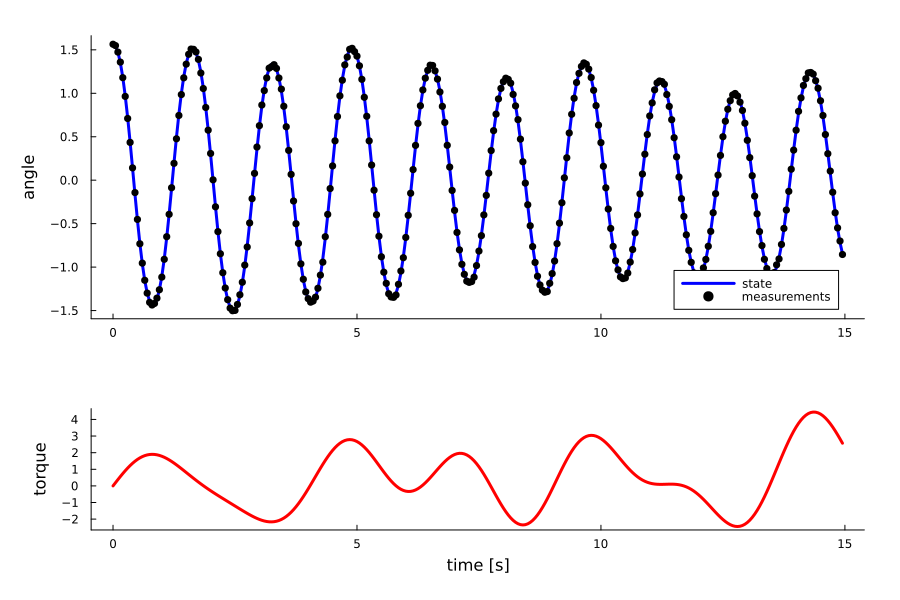

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## NARX model

In [7]:
# Polynomial degree
H = 1

# Delay order
Ly = 3
Lu = 3

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

In [8]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e-1)
pθ0 = MvNormalMeanCovariance(ones(M), 10diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


In [9]:
agent = NARXAgent(pθ0, pτ0, memory_actions=Lu, memory_senses=Ly, pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)
, GammaShapeRate{Float64}(a=1.0, b=0.1), NormalMeanVariance{Float64}(μ=0.0, v=1.0), 1, 10, 1.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

## Parameter estimation

In [10]:
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 1
preds = (zeros(N,T), zeros(N,T))

@showprogress for k in 1:N
    
    # Make predictions
    preds[1][k,:], preds[2][k,:] = predictions(agent, controls[k], time_horizon=T)
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], controls[k])
    FE[:,k] = agent.free_energy
    
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


┌ Error: Failed to revise /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/Pendulums.jl
│   exception =
│    invalid redefinition of type DPendulum
│    Stacktrace:
│     [1] top-level scope
│       @ ~/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/Pendulums.jl:29
│    Revise evaluation error at /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/Pendulums.jl:29
│    
└ @ Revise ~/.julia/packages/Revise/7HQ7u/src/packagedef.jl:723
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/Pendulums.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise ~/.julia/pac

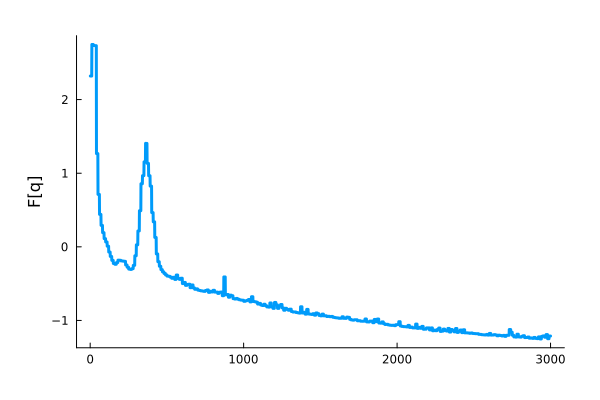

In [11]:
plot(FE[:], ylabel="F[q]")

In [12]:
limsb = [minimum(observations)*1.5, maximum(observations)*1.5]
p1 = plot(xlabel="time [steps]", title="Observations vs $T$-step ahead predictions", ylims=limsb)
scatter!(observations[2:end], color="black", label="observations")
plot!(preds[1][2:end,T], ribbon=preds[2][2:end,T], color="purple", label="k=$T prediction")

LoadError: syntax: invalid interpolation syntax: "$-"

## Expected Free Energy minimization

In [13]:
# Length of trial
N = 150
tsteps = range(0.0, step=Δt, length=N)
T = 3

# Set control properties
goal = NormalMeanVariance(1.0, 1e-4)
control_prior = 1e-2
num_iters = 10
u_lims = (-100, 100)

# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start system
init_state = [π/2, 0.0]
pendulum = SPendulum(init_state, sys_mass, sys_length, sys_damping, sys_mnoise_sd, Δt=Δt)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_ = zeros(N)
u_ = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
FE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_[k])
    y_[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_[k], u_[k])
    
    FE[:,k] = agent.free_energy
    push!(pθ, agent.qθ)
    push!(pτ, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, u_lims=u_lims)
    u_[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


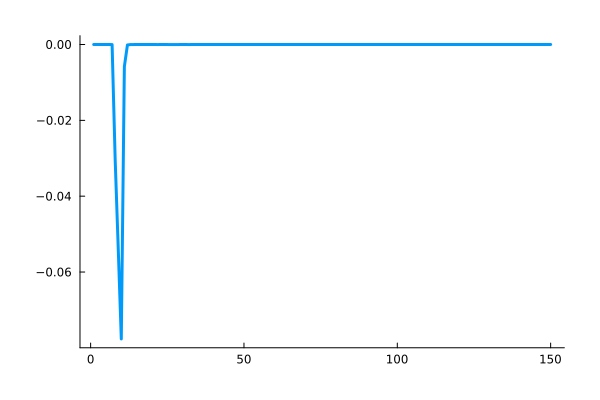

In [14]:
plot(FE[end,:] .- FE[1,:])

In [15]:
p1 = plot(tsteps, y_, color="black", label="observations")
hline!([m_star], color="green", ylims=[-1., 2.])
p4 = plot(tsteps, u_[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

LoadError: UndefVarError: `m_star` not defined

In [16]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-trial.png"

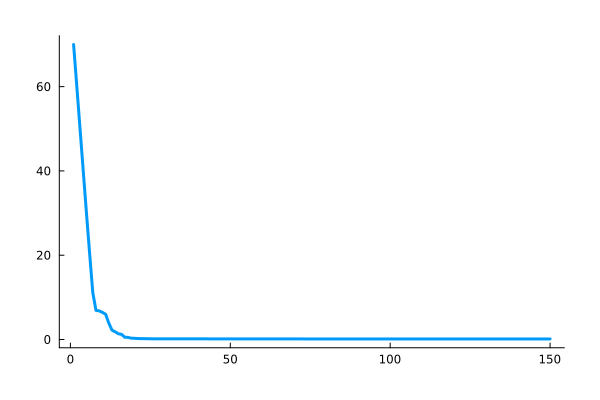

In [17]:
tSθ = [tr(cov(pθ[k])) for k in 1:N]
plot(tSθ)

In [18]:
limsb = [minimum(y_)*1.5, maximum(y_)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([m_star], color="green")
    else
        plot(tsteps[k-window:k], y_[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([m_star], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

LoadError: UndefVarError: `m_star` not defined